In [1]:

# Import the relevant modules
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Import CNTK
import cntk as C


import cntk.io.transforms as xforms
import cntk.tests.test_utils
#C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
    
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import struct
import sys
    
import glob
import socket
%matplotlib inline
import wget
import tarfile
import urllib



## References
https://github.com/soumith/ganhacks

In [53]:
if socket.gethostname() == 'dsvm1':
    root = r'/home/kumaran/Data'
else:
    root = r'E:\Temp\\'
    
data_dir = os.path.join(root, 'lfw')
#data_dir = os.path.join(root, 'MNIST')
# down data from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# model dimensions
img_h = 36
img_w  = 36

num_channels = 3
input_dim = (num_channels, img_h, img_w)
num_classes  = 2
latent_dim = 100

e_kernel_1 = (3,3)
e_stride_1 = (2,2)
e_filter_1 = 64
e_filter_2 = 128

isFast = False
epoch_size = 30000        # 30000 samples is half the dataset size
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 50 if not isFast else 500
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) // minibatch_size
num_samples_to_test = 10000

#map_file = os.path.join(data_dir, 'cntk_image_data.tsv')

In [3]:
def prepare_mapfile():
    try:
        os.mkdir(data_dir)
    except FileExistsError:
        pass
    
    if not os.path.exists(os.path.join(data_dir, 'lfw-deepfunneled.tgz')):
        urllib.request.urlretrieve('http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz', os.path.join(data_dir, 'lfw-deepfunneled.tgz'))        
        tar = tarfile.open(os.path.join(data_dir, 'lfw-deepfunneled.tgz'), mode='r|gz')
        tar.extractall(path=data_dir)
    
    if not os.path.exists(os.path.join(data_dir, 'lfw_map.tsv')):
        with open(os.path.join(data_dir, 'lfw_map.tsv'), 'w') as mapfile:
            for f in glob.glob(data_dir + '/**/*.jpg', recursive=True):
                mapfile.write('{}\t{}\n'.format(f, 1))
            
            
prepare_mapfile()
    
    

In [4]:
def create_reader_lfw(map_file, is_training):
    print("Reading map file:", map_file)    

    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    # train uses data augmentation (translation only)
    if is_training and False:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8)
        ]
    transforms += [
        xforms.scale(width=img_w, height=img_w, channels=num_channels, interpolations='linear')        
    ]    
    
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        input = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [5]:
import math
import cv2
def gridPlot(images):
    n = images.shape[0]
    c = 10
    r = math.ceil(n/c)
    fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(20, 20))
         
    for i in range(n):
        if n <= c:
            axes[i].imshow(np.asarray(images[i][0].transpose(1,2,0))/255.0)
            
        else:
            ri = i//c
            ci = i%c
            axes[ri][ci].imshow(np.asarray(cv2.cvtColor(images[i][0].transpose(1,2,0)/255.0, cv2.COLOR_BGR2RGB)))
            axes[ri][ci].axis('off')
            axes[ri][ci].set_xticklabels([])
            axes[ri][ci].set_yticklabels([])

    fig.subplots_adjust(wspace=0, hspace=0)
    
def gridPlot2(images):
    n = images.shape[0]
    c = 10 if n > 10 else 1
    r = math.ceil(n/c)
    fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(20, 20))
         
    for i in range(n):
        if n <= c:
            axes[i].imshow(np.asarray(images[i].transpose(1,2,0))/255.0)
            
        else:
            ri = i//c
            ci = i%c
            axes[ri][ci].imshow(np.asarray(cv2.cvtColor(images[i].transpose(1,2,0)/255.0, cv2.COLOR_BGR2RGB)))
            axes[ri][ci].axis('off')
            axes[ri][ci].set_xticklabels([])
            axes[ri][ci].set_yticklabels([])

    fig.subplots_adjust(wspace=0, hspace=0)
            
        #axes[i].imshow(np.asarray(images[i][0].transpose(1,2,0), dtype=np.int32))

In [6]:
reader = create_reader_lfw(os.path.join(data_dir, 'lfw_map.tsv'), True)

map = {'input': reader.streams.input, 'label': reader.streams.labels}
data = reader.next_minibatch(100, input_map=map)

data['input'].shape

Reading map file: /home/kumaran/Data/lfw/lfw_map.tsv


(64, 1, 3, 36, 36)

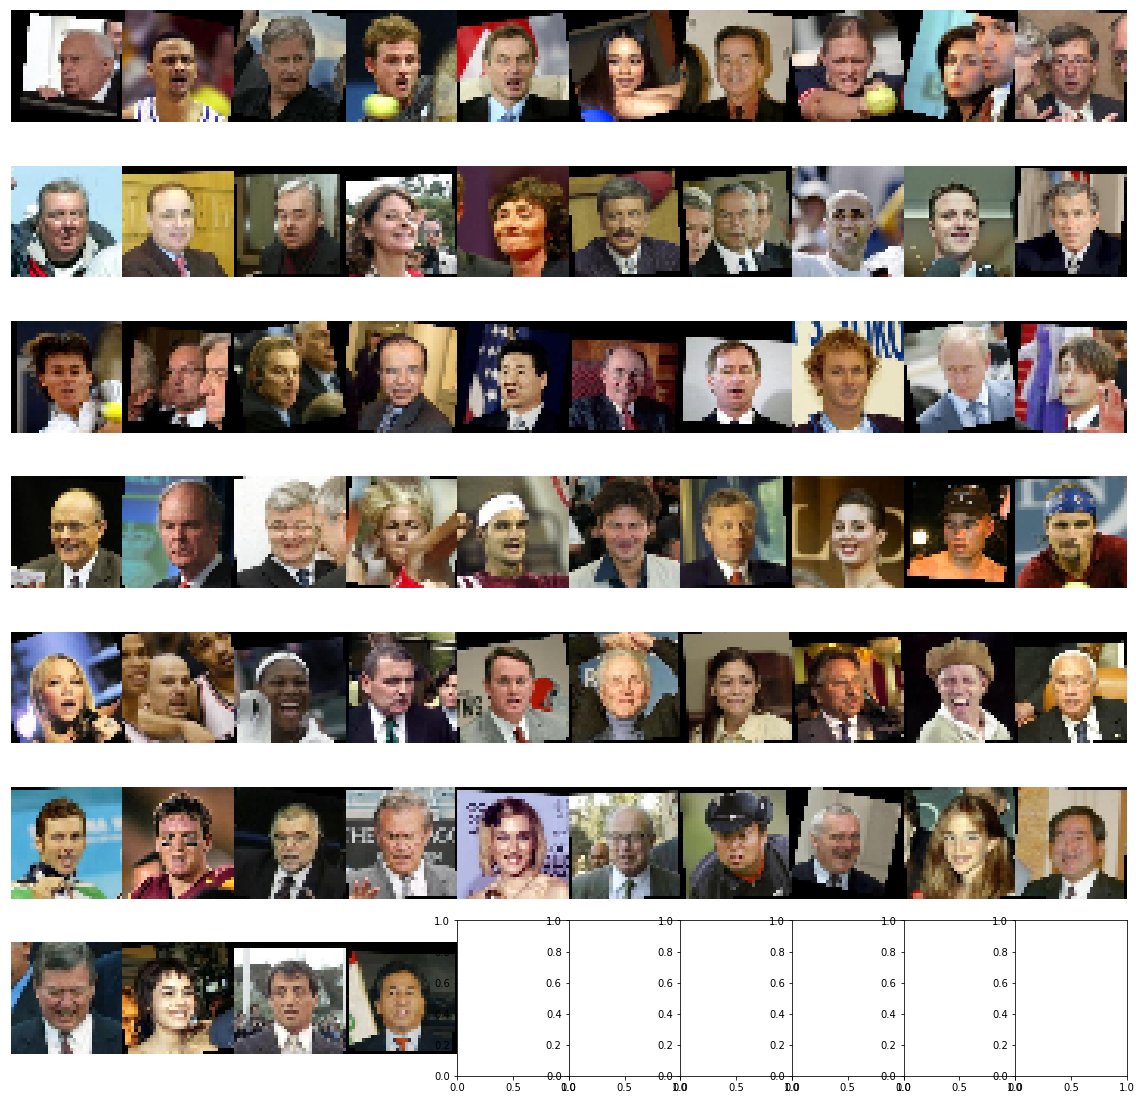

In [7]:
gridPlot(data['input'].data.asarray())

In [54]:
def bn_with_relu(x, activation=C.relu):
    h = C.layers.BatchNormalization(map_rank=1)(x)
    return C.relu(h)

# We use param-relu function to use a leak=0.2 since CNTK implementation
# of Leaky ReLU is fixed to 0.01
def bn_with_leaky_relu(x, leak=0.2):
    h = C.layers.BatchNormalization(map_rank=1)(x)
    r = C.param_relu(C.constant((np.ones(h.shape)*leak).astype(np.float32)), h)
    return r


def discriminator(input):    
    with C.layers.default_options(init=C.normal(scale=0.02)):

        print('Discriminator convolution input shape', input.shape)
        print(e_kernel_1)
        h0 = C.layers.Convolution2D(e_kernel_1, e_filter_1, strides=e_stride_1, pad=True, activation=None)(input)
        h0 = bn_with_leaky_relu(h0)

        print('h0 shape :', h0.shape)
                
        h1 = C.layers.Convolution2D(e_kernel_1, e_filter_2, strides=e_stride_1, pad=True, activation=C.relu)(h0)
        h1 = bn_with_leaky_relu(h1)
        print('h1 shape :', h1.shape)
                
        p = C.layers.Dense(1, activation=C.sigmoid)(h1)        
        print('mu shape :', p.shape)
        return p
    
def generator(z):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        
        
        print('Generator input shape: ', z.shape)
        s_h2, s_w2 = img_h//2, img_w//2 #Input shape (14,14)
        s_h4, s_w4 = img_h//4, img_w//4 # Input shape (7,7)
        
        h1 = C.layers.Dense([e_filter_2, s_h4,  s_w4], activation=None)(z)        
        h1 = bn_with_relu(h1)
        print('h1 shape', h1.shape)

        h2 = C.layers.ConvolutionTranspose2D(e_kernel_1, num_filters=e_filter_1, strides=e_stride_1, pad=True, output_shape=(s_h2, s_w2), activation=None)(h1)        
        h2 = bn_with_relu(h2)
        print('h2 shape', h2.shape)

        h3 = C.layers.ConvolutionTranspose2D(e_kernel_1, num_filters=num_channels, strides=e_stride_1, pad=True, output_shape=(img_h, img_w), activation=C.tanh)(h2)
        print('h3 shape :', h3.shape)
        

        return h3

network = {}


def get_z(num_samples):
    return np.random.normal(loc = 0, scale = 1.0, size = [num_samples, latent_dim]).astype(np.float32)
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, latent_dim]
    ).astype(np.float32)



def create_network():
    real = C.input_variable((num_channels,img_w, img_h))    
    z = C.input_variable(latent_dim)
    
    network['input'] = real
    network['z'] = z
    
    real_scaled = 2*(real / 255.0)-1

    
    network['real'] = real
    network['p_real'] = discriminator(real_scaled)
    
    #output = decoder(z)
    network['fake'] = generator(z)
    
    # replace input of discriminator with generated fake output and predict
    network['p_fake'] = network['p_real'].clone(method='share', substitutions ={real_scaled.output : network['fake'].output})
    
    # maximize log likelyhood r being face and f being not face - inputs (z, input)
    # domain [0, inf]
    d_loss = -(C.log(network['p_real']) + C.log(1.0 - network['p_fake']))
    
    # minimize log likelyhood of f being not face - inputs (z)
    # domain [-inf, 0]
    g_loss = C.log(1.0-network['p_fake'])
    g_loss = 1.0-C.log(network['p_fake'])
    
    
    network['d_loss'] = d_loss
    network['g_loss'] = g_loss
    
    network['d_error'] = d_loss
    network['g_error'] = g_loss
    
    return network

train_file = create_reader_lfw(os.path.join(data_dir, 'lfw_map.tsv'), True)



Reading map file: /home/kumaran/Data/lfw/lfw_map.tsv


In [58]:
def train(train_file, test_file):
    create_network()    
     # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00002]
    lr_schedule = C.learning_parameter_schedule_per_sample(lr_per_sample, epoch_size)
    # Momentum which is applied on every minibatch_size = 64 samples
    momentum_schedule = C.momentum_schedule(0.9, minibatch_size)    
    # only allow discriminator parameters to be updated
    d_learner = C.adam(network['p_real'].parameters,
                         lr=lr_schedule, momentum=momentum_schedule)    
    # only allow generator parameters to be updated
    g_learner = C.fsadagrad(network['fake'].parameters,
                         lr=lr_schedule, momentum=momentum_schedule)
    # print out loss for each model for upto 50 times
    print_frequency_mbsize = 1000
        
    num_minibatches_to_train_discriminator = 3
    num_minibatches_to_train_generator = 3
    
    pp_G = C.logging.ProgressPrinter(print_frequency_mbsize * num_minibatches_to_train_generator, tag='G')
    pp_D = C.logging.ProgressPrinter(print_frequency_mbsize * num_minibatches_to_train_discriminator, tag='D')

    
    d_trainer = C.Trainer(network['p_real'], (network['d_loss'], network['d_error']), d_learner, pp_D)
    g_trainer = C.Trainer(network['fake'], (network['g_loss'], network['g_error']), g_learner, pp_G)

    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        'input'  : train_file.streams.input,
        'label'  : train_file.streams.labels
    }
    
    
    total_minibatch = 0    
    num_minibatches_to_train = 100000
    while True:
        if total_minibatch > num_minibatches_to_train:
            break
        # train discriminator
        d_loss = 0.0
        d_count = 0.0
        d_loss_thres = 0.07
        while True:
            real_data = train_file.next_minibatch(minibatch_size, input_map)
            z = get_z(minibatch_size)
            batch_input = { network['input'] : real_data['input'].data, network['z']: z}
            d_trainer.train_minibatch(batch_input)
            d_loss +=  d_trainer.previous_minibatch_loss_average
            total_minibatch += 1
            d_count += 1.0
            if d_loss/d_count < d_loss_thres:
                if total_minibatch % 1000 == 0:
                    print('D break :{} {}'.format(d_loss/d_count, d_count))
                break
            
            
            
        g_loss = 0.0
        g_count = 0.0
        g_loss_thres = 1.1
        while True:
            # train one step of generator
            z = get_z(minibatch_size)
            batch_input = {network['z'] : z}
            g_trainer.train_minibatch(batch_input)
            
            g_loss +=  g_trainer.previous_minibatch_loss_average
            g_count += 1.0
            if g_loss/g_count < g_loss_thres:
                if total_minibatch % 1000 == 0:
                    print('G break :{} {}'.format(g_loss/g_count, g_count))
                break
        
    print('done')

train(train_file, train_file)

Discriminator convolution input shape (3, 36, 36)
(3, 3)
h0 shape : (64, 18, 18)
h1 shape : (128, 9, 9)
mu shape : (1,)
Generator input shape:  (100,)
h1 shape (128, 9, 9)
h2 shape (64, 18, 18)
h3 shape : (3, 36, 36)
Learning rate per 1 samples: 2e-05


/anaconda/envs/py35/lib/python3.5/site-packages/cntk/learners/__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


Learning rate per 1 samples: 2e-05
 Minibatch[   1-3000]: loss = 0.074668 * 192000, metric = 7.47% * 192000;
 Minibatch[   1-3000]: loss = 1.117629 * 192000, metric = 111.76% * 192000;
 Minibatch[3001-6000]: loss = 1.107929 * 192000, metric = 110.79% * 192000;
 Minibatch[3001-6000]: loss = 0.071692 * 192000, metric = 7.17% * 192000;
 Minibatch[6001-9000]: loss = 0.069898 * 192000, metric = 6.99% * 192000;
 Minibatch[6001-9000]: loss = 1.082977 * 192000, metric = 108.30% * 192000;
 Minibatch[9001-12000]: loss = 0.076981 * 192000, metric = 7.70% * 192000;
 Minibatch[12001-15000]: loss = 0.061480 * 192000, metric = 6.15% * 192000;
 Minibatch[9001-12000]: loss = 1.096327 * 192000, metric = 109.63% * 192000;
 Minibatch[15001-18000]: loss = 0.074450 * 192000, metric = 7.45% * 192000;
 Minibatch[18001-21000]: loss = 0.072314 * 192000, metric = 7.23% * 192000;
 Minibatch[12001-15000]: loss = 1.101858 * 192000, metric = 110.19% * 192000;
 Minibatch[21001-24000]: loss = 0.059950 * 192000, metric

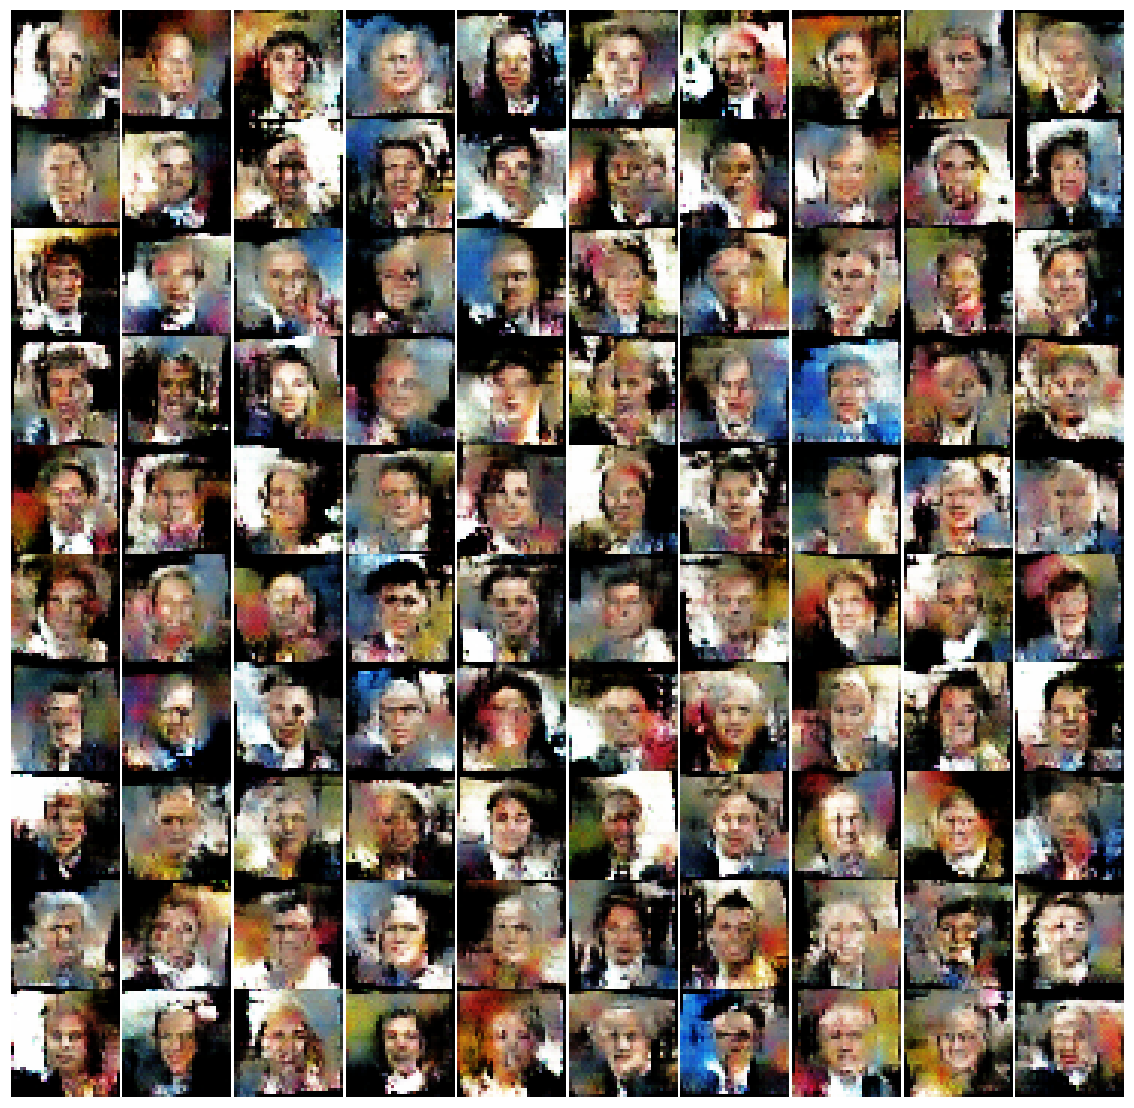

In [60]:
z = get_z(100)

fake = network['fake'].eval({network['z']: z})
fake = ((fake+1.0)/2.0) * 255.0
gridPlot2(fake)

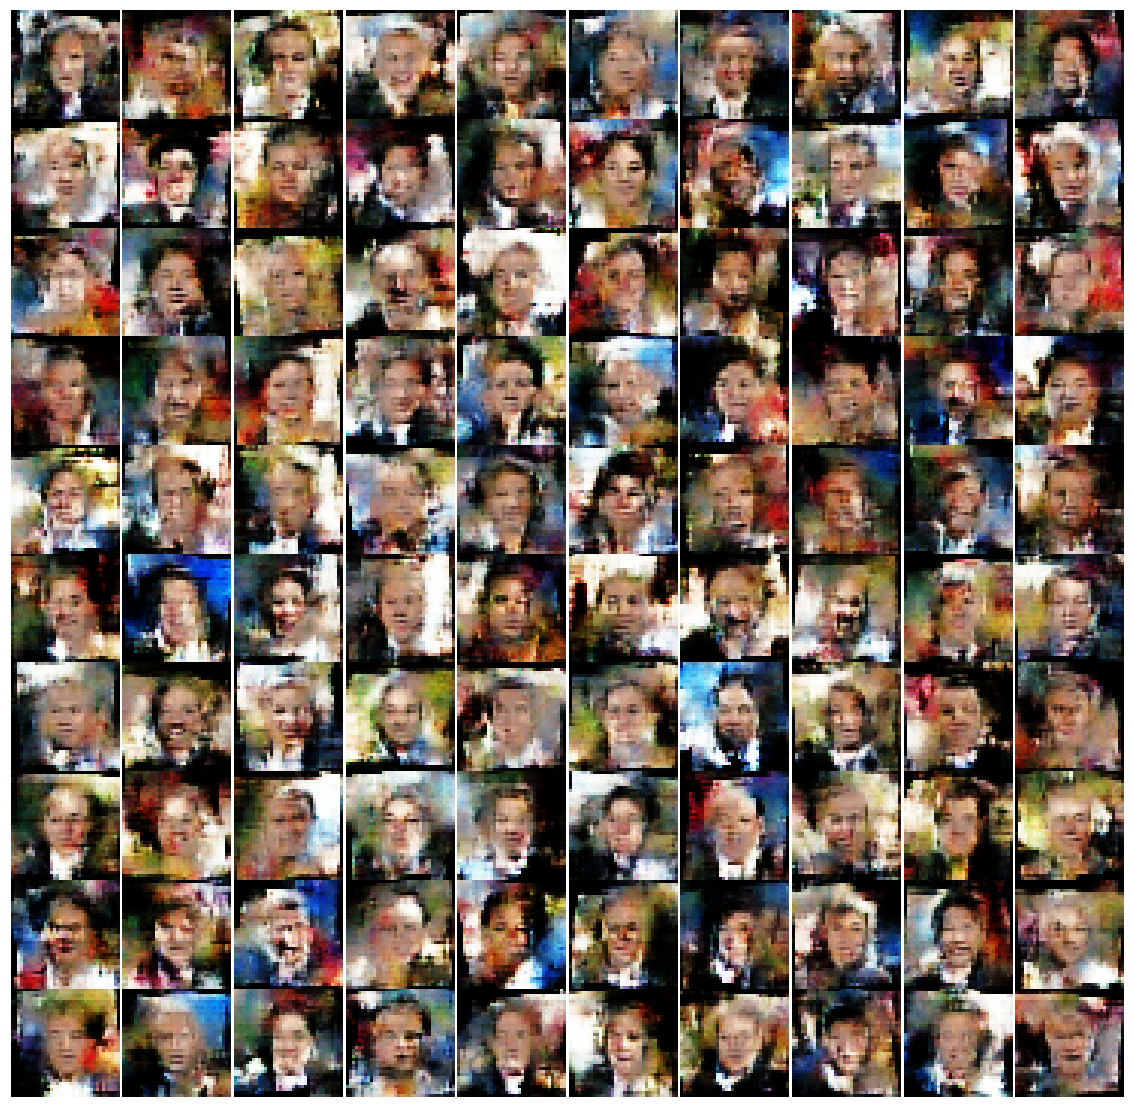

In [57]:
z = get_z(100)

fake = network['fake'].eval({network['z']: z})
fake = ((fake+1.0)/2.0) * 255.0
gridPlot2(fake)

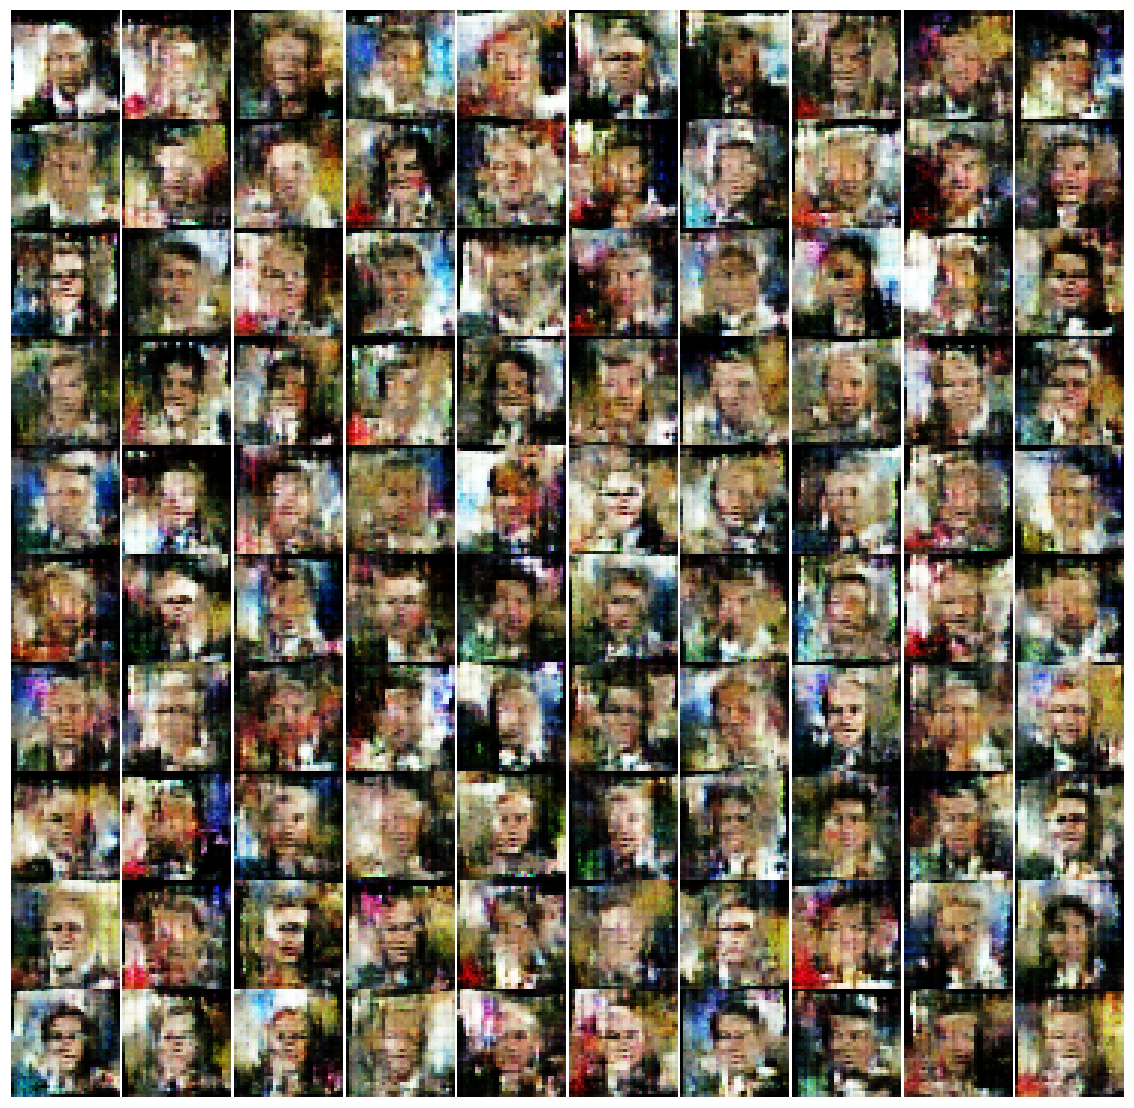

In [52]:
z = get_z(100)

fake = network['fake'].eval({network['z']: z})
fake = ((fake+1.0)/2.0) * 255.0
gridPlot2(fake)

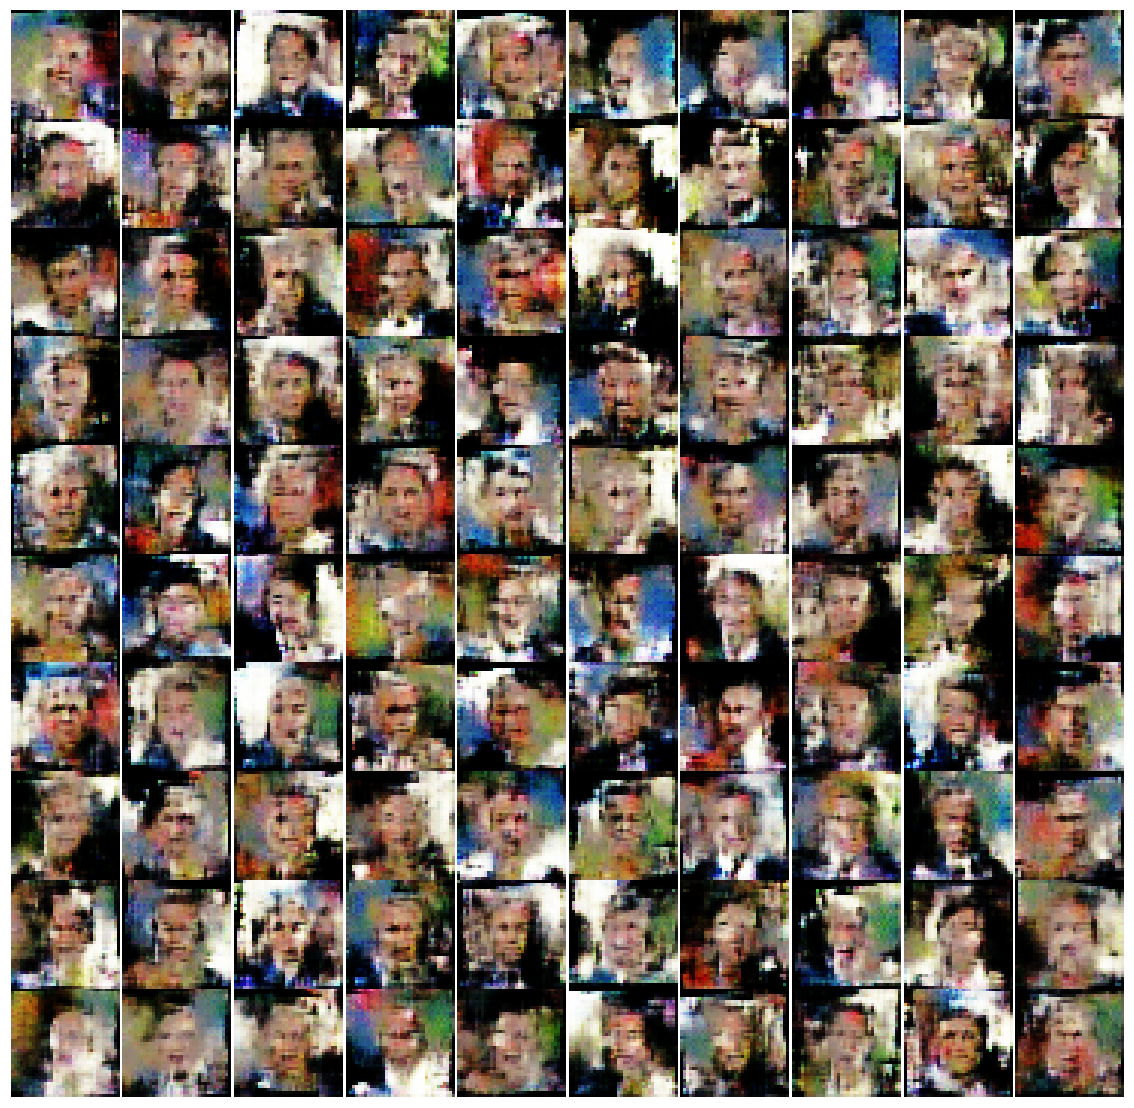

In [48]:
z = get_z(100)

fake = network['fake'].eval({network['z']: z})
fake = ((fake+1.0)/2.0) * 255.0
gridPlot2(fake)

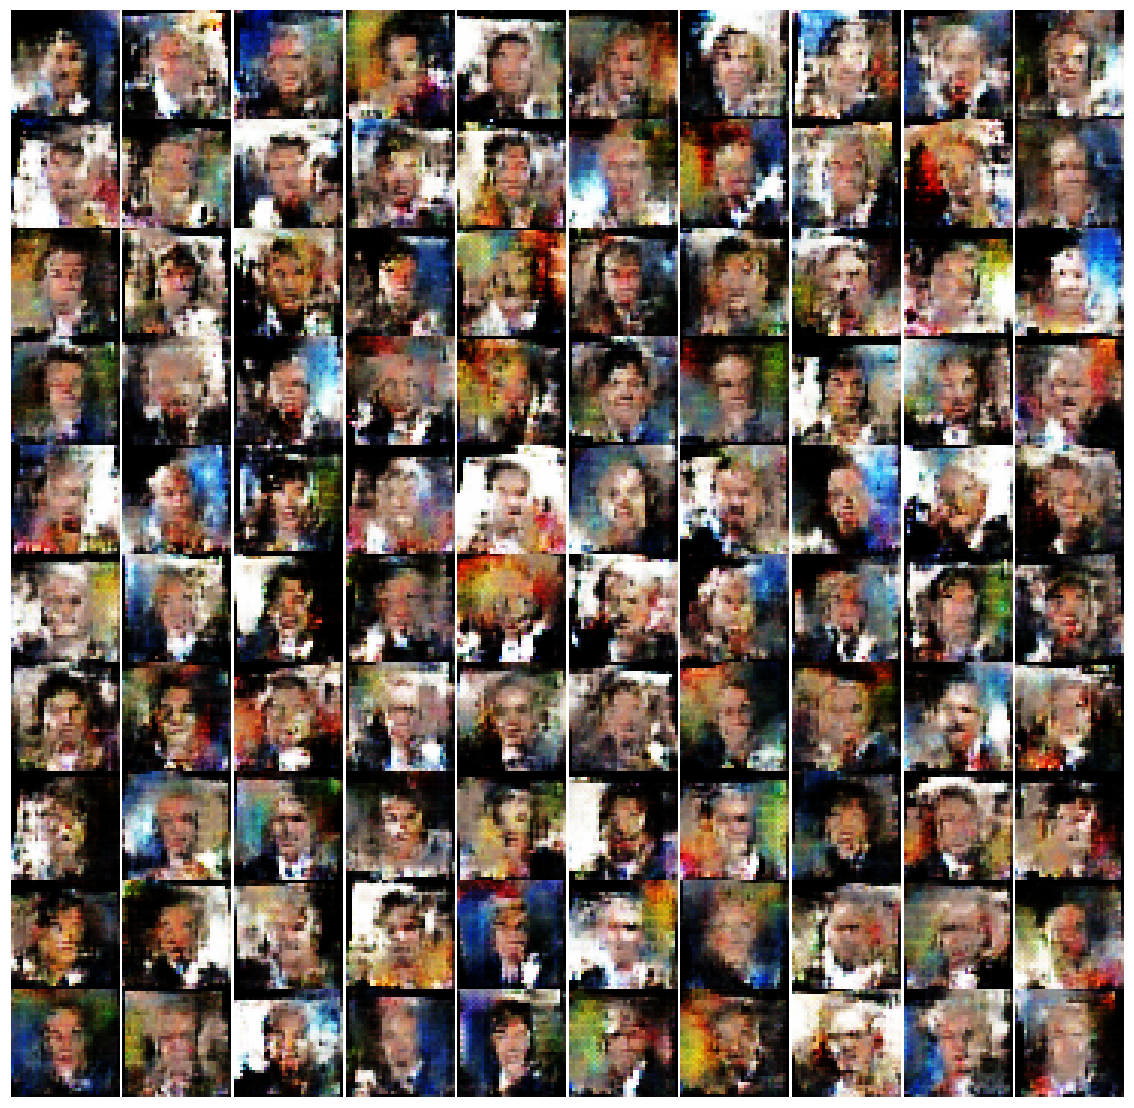

In [45]:
z = get_z(100)

fake = network['fake'].eval({network['z']: z})
fake = ((fake+1.0)/2.0) * 255.0
gridPlot2(fake)